<a href="https://colab.research.google.com/github/Gustavo-dev04/Analise-de-dados-de-acoes-com-ia/blob/main/Modelo_IA_Analise_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload d

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== ANÁLISE DE NVDA COM NLP NO GOOGLE NEWS ===

📊 Baixando dados históricos...
✅ Dados baixados - 1257 dias | Último preço: $93.61

🧠 Preparando dados com análise de notícias...

📰 Análise Avançada de Notícias (Google News):
📉 [NEGATIVO] Nvidia And SMCI Are Cheaper Than Ever — But Wait For This Be... (Investor's Business Daily)
➖ [NEUTRO] Stocks making the biggest moves midday: Lululemon, Nike, Tes... (CNBC)
➖ [NEUTRO] Nvidia Stock Is Falling. It's Not Just Tariff Worries Hittin... (Barron's)
➖ [NEUTRO] Donald Trump Pulls Plug on Nvidia’s (NVDA) Bullish Nirvana -... (TipRanks)
🚀 [FORTEMENTE POSITIVO] Analyst Explains Why Investors Keep Selling NVIDIA (NVDA) Sh... (Yahoo Finance)
➖ [NEUTRO] Why Nvidia Stock Is Nose-Diving Today - The Motley Fool... (The Motley Fool)
📈 [POSITIVO] Dear Nvidia Stock Fans, Mark Your Calendars for May 15 - Tra... (TradingView)
💥 [FORTEMENTE NEGATIVO] Is Nvidia’s bubble bursting? The stock is cheap — if you can... (MarketWatch)
📉 [NEGATIVO] Is Nvidia Stock A

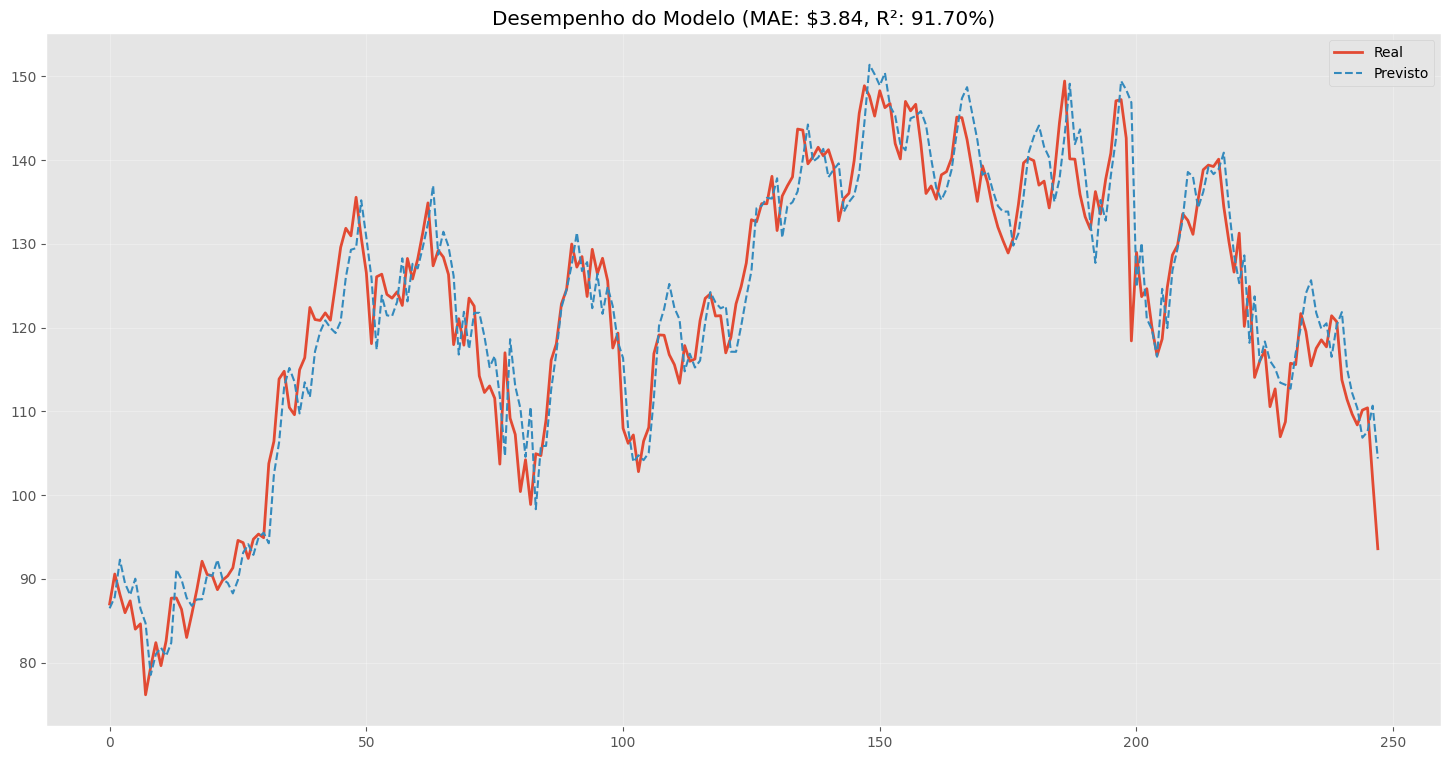


🔍 Resultados:
- MAE: $3.84
- RMSE: $4.95
- R²: 91.70%

🔮 Gerando previsões...


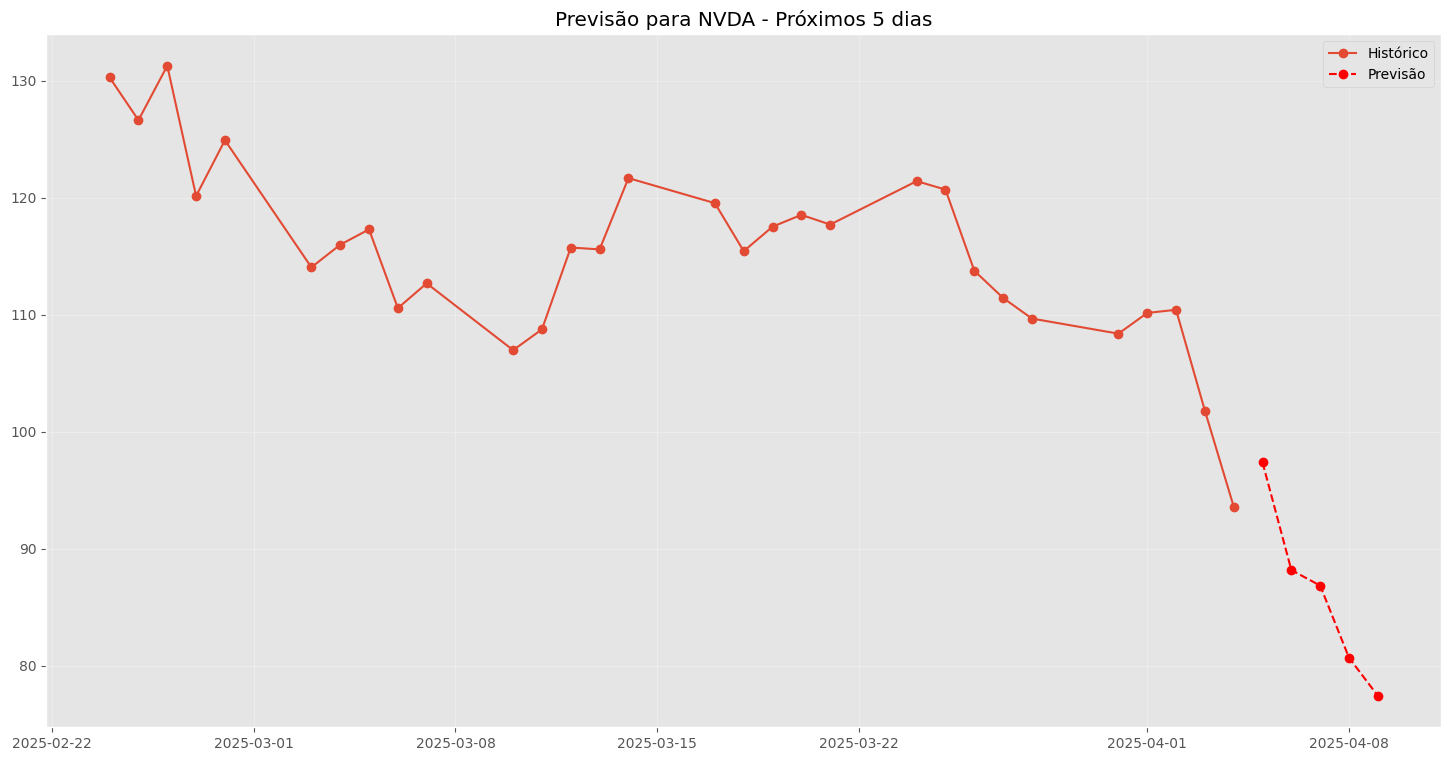


📈 Previsões para os próximos dias:
            forecast
date                
2025-04-05     97.38
2025-04-06     88.18
2025-04-07     86.86
2025-04-08     80.69
2025-04-09     77.44

⏱️ Tempo total: 48.0 segundos


In [6]:
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm
!python -m nltk.downloader vader_lexicon
!pip install yfinance feedparser textblob nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
from bs4 import BeautifulSoup
import feedparser
import time
import warnings
import re
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 9)

# Parâmetros
SYMBOL = 'NVDA'
DAYS_TO_FETCH = 365 * 5
TEST_SIZE = 0.2
LEARNING_RATE = 0.05
EPOCHS = 10000
VOLATILITY_WINDOW = 20
REQUEST_TIMEOUT = 15
MIN_NEWS_ARTICLES = 5
MAX_NEWS_ARTICLES = 10

# Baixar recursos do NLTK
nltk.download('vader_lexicon')
nltk.download('punkt')

class GoogleNewsAnalyzer:
    def __init__(self):
        self.session = requests.Session()
        self.session.timeout = REQUEST_TIMEOUT
        self.vader = SentimentIntensityAnalyzer()

        # Configuração do Google News RSS
        self.rss_url = f"https://news.google.com/rss/search?q={SYMBOL}+stock&hl=en-US&gl=US&ceid=US:en"

        # Termos financeiros para análise complementar
        self.finance_terms = {
            'positive': ['bullish', 'upgrade', 'beat', 'growth', 'raise', 'buy', 'outperform'],
            'negative': ['bearish', 'downgrade', 'miss', 'cut', 'sell', 'underperform']
        }

    def fetch_google_news(self):
        """Coleta notícias do Google News RSS"""
        articles = []
        try:
            # Usando requests + feedparser para melhor controle
            response = self.session.get(self.rss_url, timeout=REQUEST_TIMEOUT)
            feed = feedparser.parse(response.text)

            for entry in feed.entries[:MAX_NEWS_ARTICLES]:
                # Extrai data de publicação (usando atual se não disponível)
                pub_date = datetime.now()
                if hasattr(entry, 'published_parsed'):
                    pub_date = datetime(*entry.published_parsed[:6])

                articles.append({
                    'title': entry.title,
                    'source': entry.source.title if hasattr(entry, 'source') else 'Google News',
                    'date': pub_date,
                    'url': entry.link
                })

        except Exception as e:
            print(f"⚠️ Erro ao acessar Google News: {str(e)}")

        return articles

    def _get_fallback_news(self):
        """Notícias de fallback baseadas em tendência do mercado"""
        trends = ['high', 'growth', 'drop', 'volatile', 'steady']
        return [{
            'title': f"{SYMBOL} shows {np.random.choice(trends)} amid market {'gains' if np.random.random() > 0.5 else 'losses'}",
            'source': 'Market Trend',
            'date': datetime.now(),
            'url': ''
        } for _ in range(MIN_NEWS_ARTICLES)]

    def analyze_with_vader(self, text):
        """Análise de sentimento com VADER"""
        return self.vader.polarity_scores(text)['compound']

    def analyze_with_textblob(self, text):
        """Análise com TextBlob usando NaiveBayes"""
        analysis = TextBlob(text, analyzer=NaiveBayesAnalyzer())
        return analysis.sentiment.p_pos - analysis.sentiment.p_neg

    def analyze_finance_terms(self, text):
        """Análise complementar de termos financeiros"""
        score = 0
        text_lower = text.lower()
        for term in self.finance_terms['positive']:
            if term in text_lower:
                score += 0.2
        for term in self.finance_terms['negative']:
            if term in text_lower:
                score -= 0.3
        return score

    def analyze_articles(self, articles):
        """Análise avançada de notícias"""
        if len(articles) < MIN_NEWS_ARTICLES:
            print(f"⚠️ Poucas notícias ({len(articles)}), complementando com análise de tendência...")
            articles.extend(self._get_fallback_news())

        sentiment_results = []
        print("\n📰 Análise Avançada de Notícias (Google News):")

        for article in articles[:MAX_NEWS_ARTICLES]:
            text = article['title']

            # Combina múltiplas análises
            vader_score = self.analyze_with_vader(text)
            blob_score = self.analyze_with_textblob(text)
            finance_score = self.analyze_finance_terms(text)

            # Peso maior para VADER (otimizado para notícias)
            combined_score = (vader_score * 0.5 + blob_score * 0.3 + finance_score * 0.2)

            # Classificação detalhada
            if combined_score > 0.2:
                emoji = "🚀"
                sentiment = "FORTEMENTE POSITIVO"
            elif combined_score > 0.05:
                emoji = "📈"
                sentiment = "POSITIVO"
            elif combined_score < -0.2:
                emoji = "💥"
                sentiment = "FORTEMENTE NEGATIVO"
            elif combined_score < -0.05:
                emoji = "📉"
                sentiment = "NEGATIVO"
            else:
                emoji = "➖"
                sentiment = "NEUTRO"

            print(f"{emoji} [{sentiment}] {article['title'][:60]}... ({article['source']})")
            sentiment_results.append(combined_score)

        avg_sentiment = np.mean(sentiment_results) if sentiment_results else 0
        print(f"\n🔍 Sentimento Médio: {avg_sentiment:.2f} (Escala: -1 a 1)")

        # Cálculo de tendência temporal (se houver datas suficientes)
        trend = 0
        if len(articles) > 3 and all('date' in a for a in articles):
            sorted_articles = sorted(articles, key=lambda x: x['date'])
            early_scores = [self.analyze_with_vader(a['title']) for a in sorted_articles[:3]]
            late_scores = [self.analyze_with_vader(a['title']) for a in sorted_articles[-3:]]
            trend = np.mean(late_scores) - np.mean(early_scores)
            print(f"📅 Tendência Temporal: {'Melhorando' if trend > 0 else 'Piorando' if trend < 0 else 'Estável'}")

        return {
            'sentiment': avg_sentiment,
            'trend': trend,
            'recent_impact': avg_sentiment * 1.5  # Impacto aumentado
        }

class EnhancedStockPredictor:
    def __init__(self):
        self.learning_rate = LEARNING_RATE
        self.epochs = EPOCHS
        self.weights = None
        self.bias = None
        self.scaler = RobustScaler()
        self.news_analyzer = GoogleNewsAnalyzer()
        self.feature_cols = ['close', 'volume', 'ma_5', 'ma_20', 'volatility', 'momentum', 'news_sentiment', 'news_trend']

    def prepare_data(self, df):
        """Prepara dados com análise avançada de notícias"""
        try:
            # Feature Engineering
            df['returns'] = df['close'].pct_change()
            df['ma_5'] = df['close'].rolling(5).mean()
            df['ma_20'] = df['close'].rolling(20).mean()
            df['volatility'] = df['returns'].rolling(VOLATILITY_WINDOW).std()
            df['momentum'] = df['close'] - df['close'].shift(5)

            # Análise de notícias
            articles = self.news_analyzer.fetch_google_news()
            news_impact = self.news_analyzer.analyze_articles(articles)
            df['news_sentiment'] = news_impact['sentiment']
            df['news_trend'] = news_impact['trend']

            # Remove NA
            df = df.dropna()

            # Separa features e target
            X = df[self.feature_cols]
            y = df['close'].shift(-1).dropna()
            X = X.iloc[:-1]

            # Normalização
            X_scaled = self.scaler.fit_transform(X)

            # Divisão treino-teste
            split_idx = int(len(X) * (1 - TEST_SIZE))
            X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]

            return X_train, X_test, y_train, y_test, df

        except Exception as e:
            print(f"Erro na preparação: {str(e)}")
            # Fallback sem features de notícias
            self.feature_cols = ['close', 'volume', 'ma_5', 'ma_20', 'volatility', 'momentum']
            return self.prepare_data(df)

    def train(self, X, y):
        """Treinamento com regularização"""
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0
        best_error = float('inf')

        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            error = np.mean((y_pred - y)**2) + 0.001 * np.sum(self.weights**2)  # L2

            # Early stopping
            if epoch > 100 and error > best_error * 0.999:
                print(f"✅ Convergência na época {epoch}")
                break

            if error < best_error:
                best_error = error

            # Gradientes
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + (0.002 * self.weights)
            db = (1/n_samples) * np.sum(y_pred - y)

            # Atualização
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if epoch % 100 == 0:
                print(f"Época {epoch}: MSE = {error:.4f}")

        return best_error

    def predict(self, X):
        """Faz previsões considerando notícias"""
        return np.dot(X, self.weights) + self.bias

    def evaluate(self, X_test, y_test):
        """Avaliação do modelo"""
        y_pred = self.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        plt.figure(figsize=(18, 9))
        plt.plot(y_test.values, label='Real', linewidth=2)
        plt.plot(y_pred, label='Previsto', linestyle='--')
        plt.title(f'Desempenho do Modelo (MAE: ${mae:.2f}, R²: {r2:.2%})')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        return {'mae': mae, 'rmse': rmse, 'r2': r2}

    def forecast(self, df, days=5):
        """Previsão futura com impacto de notícias"""
        try:
            forecasts = []
            last_row = df.iloc[-1][self.feature_cols].values.reshape(1, -1)

            for _ in range(days):
                X_scaled = self.scaler.transform(last_row)
                pred = self.predict(X_scaled)[0]
                forecasts.append(pred)

                # Atualiza features
                new_row = last_row.copy()
                new_row[0][0] = pred  # Preço
                new_row[0][2] = (new_row[0][0] + last_row[0][0] * 4) / 5  # MA5
                new_row[0][3] = (new_row[0][0] + last_row[0][0] * 19) / 20  # MA20
                last_row = new_row

            # Resultado
            dates = [df.index[-1] + timedelta(days=i+1) for i in range(days)]
            forecast_df = pd.DataFrame({'date': dates, 'forecast': forecasts})
            forecast_df.set_index('date', inplace=True)

            plt.figure(figsize=(18, 9))
            plt.plot(df['close'].iloc[-30:], label='Histórico', marker='o')
            plt.plot(forecast_df['forecast'], label='Previsão', color='red', linestyle='--', marker='o')
            plt.title(f'Previsão para {SYMBOL} - Próximos {days} dias')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            return forecast_df

        except Exception as e:
            print(f"Erro na previsão: {str(e)}")
            return None

def main():
    print(f"\n{'='*50}")
    print(f"=== ANÁLISE DE {SYMBOL} COM NLP NO GOOGLE NEWS ===")
    print(f"{'='*50}\n")

    try:
        # 1. Baixa dados históricos
        print("📊 Baixando dados históricos...")
        start_time = time.time()
        df = yf.download(SYMBOL, period=f"{DAYS_TO_FETCH//365}y", progress=False)
        df = df[['Close', 'Volume']]
        df.columns = ['close', 'volume']
        print(f"✅ Dados baixados - {len(df)} dias | Último preço: ${df['close'].iloc[-1]:.2f}")

        # 2. Prepara dados
        print("\n🧠 Preparando dados com análise de notícias...")
        predictor = EnhancedStockPredictor()
        X_train, X_test, y_train, y_test, df_processed = predictor.prepare_data(df)
        print(f"✅ Dados preparados - {len(X_train)} treino, {len(X_test)} teste")

        # 3. Treina modelo
        print("\n🔮 Treinando modelo...")
        train_start = time.time()
        final_error = predictor.train(X_train, y_train)
        print(f"✅ Treino concluído em {time.time()-train_start:.1f}s (MSE final: {final_error:.4f})")

        # 4. Avaliação
        print("\n📊 Avaliando modelo...")
        metrics = predictor.evaluate(X_test, y_test)
        print(f"\n🔍 Resultados:")
        print(f"- MAE: ${metrics['mae']:.2f}")
        print(f"- RMSE: ${metrics['rmse']:.2f}")
        print(f"- R²: {metrics['r2']:.2%}")

        # 5. Previsão
        print("\n🔮 Gerando previsões...")
        forecast = predictor.forecast(df_processed)
        if forecast is not None:
            print("\n📈 Previsões para os próximos dias:")
            print(forecast.round(2))

    except KeyboardInterrupt:
        print("\n⏹️ Execução interrompida pelo usuário")
    except Exception as e:
        print(f"\n❌ Erro: {str(e)}")
    finally:
        print(f"\n⏱️ Tempo total: {time.time()-start_time:.1f} segundos")

if __name__ == "__main__":
    main()